In [37]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

Read the data file.

In [38]:
# Import the main data set
data = pd.read_pickle('df_LA_parcels_LAcity_cleaned_REV3_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000] # Set price to under 2 million. Too generalized if all home prices included.
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier (only 1 data point)
data = data[data['LandBaseYear'] >= 2015] # Remove homes that have not been sold in a very long time, data is likely inaccurate
data.shape[0] # Check number of data points remaining

87496

In [39]:
# Import the number of crimes committed in each neighborhood from 2010 to 2019
crime_data = pd.read_csv('neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')

In [40]:
# Import the custom clustering from the EDA section of this project.
# Clustered based on geographical area and median TotalValue to distinguish between rich and poor neighborhoods
neighborhood_cluster_data = pd.read_pickle('neighborhoods_cluster.pkl')
neighborhood_cluster_data['cluster'] = neighborhood_cluster_data['cluster'].astype(int) # Convert from object to int
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')

In [41]:
# Import the number of times a home has been sold in the past 15 years
sold_frequency_data = pd.read_pickle('df_LAcity_parcels_numberSold.pkl')
data = data.merge(sold_frequency_data, on = 'AIN')

Drop irrelevant columns.

In [42]:
data = data.drop(columns = ['AIN', 'Cluster', 'ZIPcode5', 'ZIPcode4', 'geometry'])
data.head()

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,...,C_score,BI_score,ID_score,Wd_score,LL_score,ShapeSTAre,ShapeSTLen,crime_count,cluster,NumberSold
0,2529.0,5,3,478659.0,2015,880822.0,1964,1964,0101,16,...,1,1,1,1,1,11926.526367,439.249106,5010,4,1
1,2776.0,5,5,467980.0,2019,927509.0,1979,1985,0101,16,...,1,1,1,1,1,7509.874023,364.494869,5010,4,2
2,1875.0,4,2,527135.0,2019,788383.0,1963,1963,0101,16,...,2,2,1,1,1,11025.290039,428.316700,5010,4,1
3,2414.0,4,3,522291.0,2019,772924.0,1976,1976,0101,16,...,1,1,1,1,1,8343.906250,396.337344,5010,4,1
4,1303.0,3,2,411484.0,2015,558488.0,1961,1961,0100,16,...,1,1,1,1,1,7525.905273,359.202499,5010,4,2


Check out the correlation between each of the current features of the data set.

In [43]:
correlation = data.corr()

<AxesSubplot:>

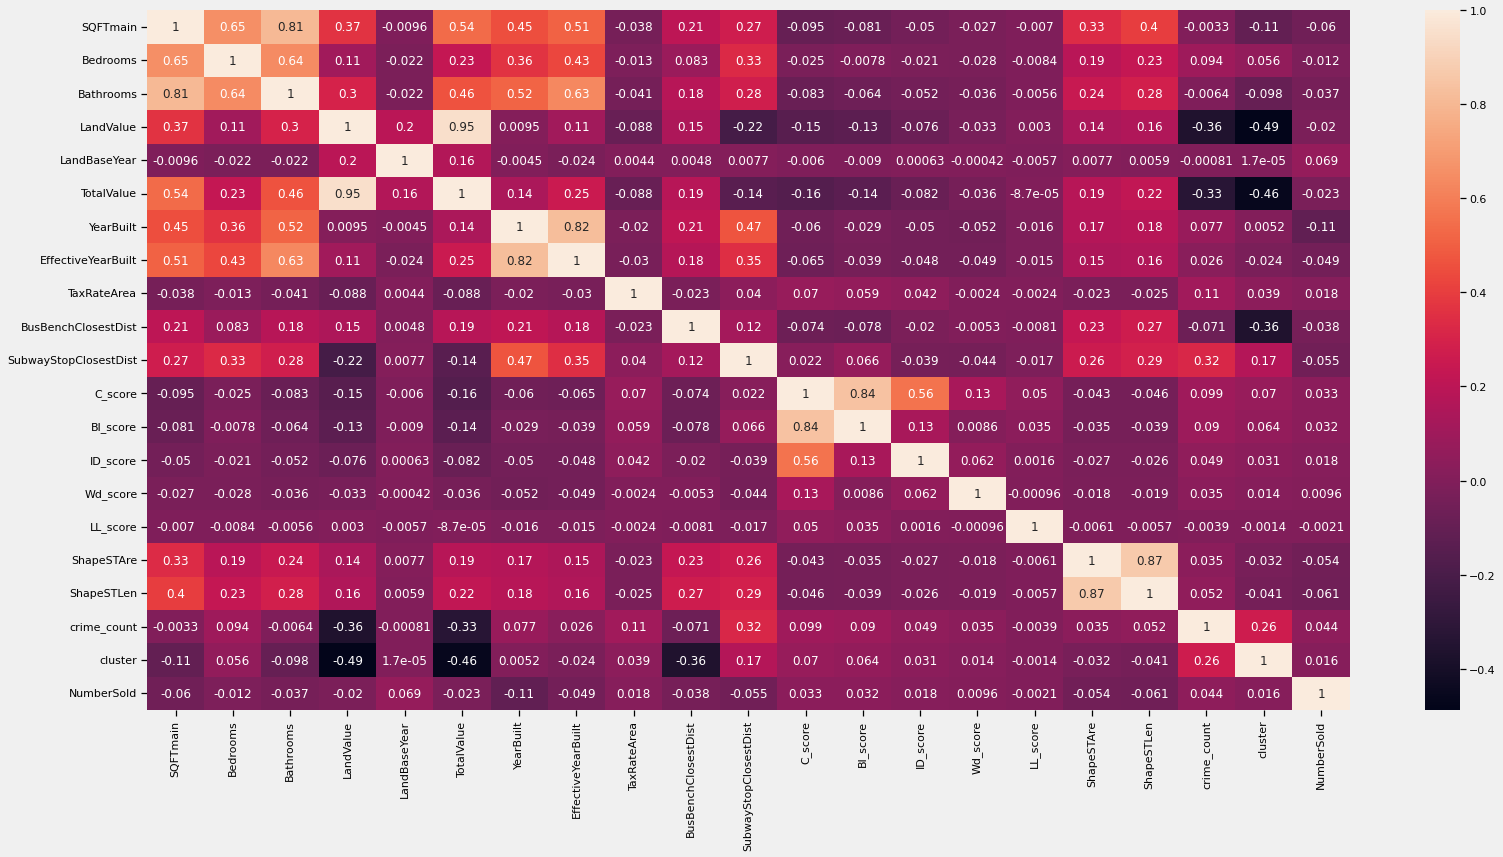

In [44]:
plt.figure(figsize = (24, 12))
sns.heatmap(correlation, annot=True)

Look at the info of each column in the data set.

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87496 entries, 0 to 87495
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SQFTmain               87496 non-null  float64
 1   Bedrooms               87496 non-null  int64  
 2   Bathrooms              87496 non-null  int64  
 3   LandValue              87496 non-null  float64
 4   LandBaseYear           87496 non-null  int64  
 5   TotalValue             87496 non-null  float64
 6   YearBuilt              87496 non-null  int64  
 7   EffectiveYearBuilt     87496 non-null  int64  
 8   PropertyUseCode        87496 non-null  object 
 9   TaxRateArea            87496 non-null  int64  
 10  BusBenchClosestDist    87496 non-null  float64
 11  SubwayStopClosestDist  87496 non-null  float64
 12  Neighborhood           87496 non-null  object 
 13  C_score                87496 non-null  int64  
 14  BI_score               87496 non-null  int64  
 15  ID

In [46]:
data.isnull().sum()

SQFTmain                 0
Bedrooms                 0
Bathrooms                0
LandValue                0
LandBaseYear             0
TotalValue               0
YearBuilt                0
EffectiveYearBuilt       0
PropertyUseCode          0
TaxRateArea              0
BusBenchClosestDist      0
SubwayStopClosestDist    0
Neighborhood             0
C_score                  0
BI_score                 0
ID_score                 0
Wd_score                 0
LL_score                 0
ShapeSTAre               0
ShapeSTLen               0
crime_count              0
cluster                  0
NumberSold               0
dtype: int64

Label the data into groups based on TotalValue, split into 4 groups. This is for stratifying the dataset when splitting into train, test, val sets so that the data split is balanced.

In [47]:
# Group the data into Quartiles based on TotalValue for stratifying purposes
data['Quartile_Number'] = 0

data.loc[
    (data['TotalValue'] >= 0) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.25)), 
    'Quartile_Number'] = 1

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.25)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.5)), 
    'Quartile_Number'] = 2

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.5)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 3

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 4

Split the data into training set, validation set, and test set.

In [48]:
train, evaluate = train_test_split(data, test_size = 0.3, random_state = 0, stratify = data['Quartile_Number'])
val, test = train_test_split(evaluate, test_size = 0.5, random_state = 0, stratify = evaluate['Quartile_Number'])

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.99977141812197%
Val 14.999542836243943%
Test 15.000685745634085%


## Feature Engineering

In [49]:
# Find relevant median values (by neighborhood and land base year) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'LandBaseYear', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'TotalValue', 'LandValue']]
    .groupby(['Neighborhood', 'LandBaseYear']).median()
)

In [50]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'TotalValue', 'LandValue']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(train)

## Gradient Descent

In [51]:
# Potential columns of interest
training_data.columns.to_list()

['SQFTmain',
 'Bedrooms',
 'Bathrooms',
 'LandValue',
 'LandBaseYear',
 'TotalValue',
 'YearBuilt',
 'EffectiveYearBuilt',
 'PropertyUseCode',
 'TaxRateArea',
 'BusBenchClosestDist',
 'SubwayStopClosestDist',
 'Neighborhood',
 'C_score',
 'BI_score',
 'ID_score',
 'Wd_score',
 'LL_score',
 'ShapeSTAre',
 'ShapeSTLen',
 'crime_count',
 'cluster',
 'NumberSold',
 'Quartile_Number',
 'YearBuilt_median',
 'EffectiveYearBuilt_median',
 'SQFTmain_median',
 'TotalValue_median',
 'LandValue_median']

In [52]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [53]:
# Standardize features using standard scaling
def standardize_data(data, columns):
    """
    Standardize all the data to be number of std away from the mean.
    """
    
    for column in columns:
        data[column] = (data[column] - data[column].mean())/data[column].std()
    
    return data

### Try with Four Features

In [54]:
def process_data_GD(data):
    """Combine all pipelines to create processed data."""
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Quartile_Number',
                         'TotalValue',
                         'TotalValue_median',
                         'LandValue_median'
                         )
    
    # Standardize Data using Standard Scaling
    columns = [
     'SQFTmain',
     'Quartile_Number',
     'TotalValue_median',
     'LandValue_median'
    ]
    
    data = standardize_data(data, columns)
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

In [55]:
X_train, y_train = process_data_GD(train)
    
X_train.head()

,SQFTmain,Quartile_Number,TotalValue_median,LandValue_median
0,-0.506503,-0.448196,-0.775855,-0.66461
1,-0.845020,-1.342938,-0.775855,-0.66461
2,-0.808313,-0.448196,-0.775855,-0.66461
3,-0.806954,-1.342938,-0.775855,-0.66461
4,0.313280,0.446545,-0.775855,-0.66461


In [56]:
def mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    return np.mean((y_hat - y) ** 2)

def grad_mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    n = X.shape[0]
    grad_0 = (-2 / n) * sum(y - y_hat)
    grad_1 = (-2 / n) * sum(X.iloc[:, 0] * (y - y_hat)) 
    grad_2 = (-2 / n) * sum(X.iloc[:, 1] * (y - y_hat)) 
    grad_3 = (-2 / n) * sum(X.iloc[:, 2] * (y - y_hat)) 
    grad_4 = (-2 / n) * sum(X.iloc[:, 3] * (y - y_hat)) 
    return grad_0, grad_1, grad_2, grad_3, grad_4

In [57]:
def minimize_GD(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
    """
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once all thetas change less than 0.001 between iterations.
    """
    
    # Set starting epoch
    epochs = np.arange(epochs)
    epochs_conv = []
    
    # Set loss array
#     losses = []
    losses_conv = []
    
    # Set theta array
#     theta0s = []
#     theta1s = []
#     theta2s = []
#     theta3s = []
#     theta4s = []
    
    # Set starting theta
    theta0 = 10
    theta1 = 10
    theta2 = 10
    theta3 = 10
    theta4 = 10
    
    for epoch in epochs:

        # Update losses
#         losses.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
        
        # Update thetas
#         theta0s.append(theta0)
#         theta1s.append(theta1)
#         theta1s.append(theta2)
#         theta1s.append(theta3)
#         theta1s.append(theta4)
        
        # Compute gradient
        grad_0, grad_1, grad_2, grad_3, grad_4 = grad_loss_fn(theta0, theta1, theta2, theta3, theta4, X, y)
        
        # Get new theta
        new_theta0 = theta0 - alpha * grad_0
        new_theta1 = theta1 - alpha * grad_1
        new_theta2 = theta2 - alpha * grad_2
        new_theta3 = theta3 - alpha * grad_3
        new_theta4 = theta4 - alpha * grad_4
        
        if (
            abs((new_theta0 - theta0)/theta0) < 0.001
            and abs((new_theta1 - theta1)/theta1) < 0.001
            and abs((new_theta2 - theta2)/theta2) < 0.001
            and abs((new_theta3 - theta3)/theta3) < 0.001
            and abs((new_theta4 - theta4)/theta4) < 0.001
            or epoch == epochs[-1]
        ):
            epochs_conv.append(epoch)
            losses_conv.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
            break
          
        # Update theta
        theta0 = new_theta0
        theta1 = new_theta1
        theta2 = new_theta2
        theta3 = new_theta3
        theta4 = new_theta4
        
    return theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv

In [58]:
# Apply 4D Gradient Descent on training set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_train,
    y = y_train,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_train)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 813863.6002579718
Theta1 (Coefficient for SQFTmain): 82267.97742521136
Theta2 (Coefficient for Bathrooms): 196243.24046468444
Theta3 (Coefficient for LandBaseYear): -104853.78907078532
Theta4 (Coefficient for LandValue): 253788.43558102424
Number of epochs: 698
RMSE score: $151845.27282317737
RMSE Accuracy Score: 81.34266322083373%


In [59]:
X_val, y_val = process_data_GD(val)

# Apply 4D Gradient Descent on validation set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_val,
    y = y_val,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_val)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 813634.7172355988
Theta1 (Coefficient for SQFTmain): 77332.70046267436
Theta2 (Coefficient for Bathrooms): 197627.0425661041
Theta3 (Coefficient for LandBaseYear): -47179.92794653951
Theta4 (Coefficient for LandValue): 194991.4162611919
Number of epochs: 744
RMSE score: $153643.5436473993
RMSE Accuracy Score: 81.11639776515219%


In [60]:
X_test, y_test = process_data_GD(test)

# Apply 4D Gradient Descent on validation set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_test,
    y = y_test,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_test)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 812696.7612190476
Theta1 (Coefficient for SQFTmain): 75747.99506741458
Theta2 (Coefficient for Bathrooms): 197815.91328731534
Theta3 (Coefficient for LandBaseYear): -79570.62140483942
Theta4 (Coefficient for LandValue): 230868.0256124092
Number of epochs: 684
RMSE score: $150340.86086785348
RMSE Accuracy Score: 81.50098929367681%


### Try with 2 Features

Turned out to be significantly worse than the 4D Gradient Descent, so this will not be used.

In [61]:
# def process_data_GD_2D(data):
#     """Combine all pipelines to create processed data."""
#     # Transform Data, Select Features
#     data = select_columns(data, 
#                          'LandValue',
#                          'Quartile_Number',
#                          'TotalValue'
#                          )
    
#     # Standardize Data using Standard Scaling
#     columns = ['LandValue', 'Quartile_Number']
    
#     data = standardize_data(data, columns)
    
#     # Return predictors and response variables separately
#     X = data.drop(['TotalValue'], axis = 1)
#     y = data.loc[:, 'TotalValue']
    
#     return X, y

In [62]:
# X_train, y_train = process_data_GD_2D(train)
    
# X_train.head()

In [63]:
# def mse_2D(theta0, theta1, theta2, X, y):
#     y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1]
#     return np.mean((y_hat - y) ** 2)

# def grad_mse_2D(theta0, theta1, theta2, X, y):
#     y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1]
#     n = X.shape[0]
#     grad_0 = (-2 / n) * sum(y - y_hat)
#     grad_1 = (-2 / n) * sum(X.iloc[:, 0] * (y - y_hat)) 
#     grad_2 = (-2 / n) * sum(X.iloc[:, 1] * (y - y_hat)) 
    
#     return grad_0, grad_1, grad_2

In [64]:
# def minimize_GD_2D(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
#     """
#     Uses gradient descent to minimize loss_fn. Returns the minimizing value of
#     theta once all thetas change less than 0.001 between iterations.
#     """
    
#     # Set starting epoch
#     epochs = np.arange(epochs)
#     epochs_conv = []
    
#     # Set loss array
# #     losses = []
#     losses_conv = []
    
#     # Set theta array
# #     theta0s = []
# #     theta1s = []
# #     theta2s = []
    
#     # Set starting theta
#     theta0 = 10
#     theta1 = 10
#     theta2 = 10
    
#     for epoch in epochs:

#         # Update losses
# #         losses.append(loss_fn(theta0, theta1, theta2, X, y))
        
#         # Update thetas
# #         theta0s.append(theta0)
# #         theta1s.append(theta1)
# #         theta2s.append(theta2)
        
#         # Compute gradient
#         grad_0, grad_1, grad_2 = grad_loss_fn(theta0, theta1, theta2, X, y)
        
#         # Get new theta
#         new_theta0 = theta0 - alpha * grad_0
#         new_theta1 = theta1 - alpha * grad_1
#         new_theta2 = theta2 - alpha * grad_2
        
#         if (
#             abs(new_theta0 - theta0) < 0.001 
#             and abs(new_theta1 - theta1) < 0.001
#             and abs(new_theta2 - theta2) < 0.001
#             or epoch == epochs[-1]
#         ):
#             epochs_conv.append(epoch)
#             losses_conv.append(loss_fn(theta0, theta1, theta2, X, y))
#             break
          
#         # Update theta
#         theta0 = new_theta0
#         theta1 = new_theta1
#         theta2 = new_theta2
        
#     return theta0, theta1, theta2, epochs_conv, losses_conv

In [65]:
# # Apply 2D Gradient Descent on training set to find home prices
# theta0, theta1, theta2, epochs_conv, losses_conv = minimize_GD_2D(
#     epochs = 1000,
#     loss_fn = mse_2D,
#     grad_loss_fn = grad_mse_2D,
#     X = X_train,
#     y = y_train,
#     alpha = 0.2
# )

# # Find the mean home value
# mean_home_values = np.mean(y_train)

# # Print Results
# print('Theta0 (Y-Intercept): {}'.format(theta0))
# print('Theta1 (Coefficient for LandValue): {}'.format(theta1))
# print('Theta2 (Coefficient for LandBaseYear): {}'.format(theta2))
# print('Number of epochs: {}'.format(epochs_conv[0]))
# print('RMSE score: ${}'.format(losses_conv[0]**0.5))
# print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))